In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# Setup

In [2]:
import torch 

import albumentations as A

from torch.utils.data import DataLoader
from coralscapesScripts.datasets.dataset import Coralscapes
from coralscapesScripts.datasets.preprocess import get_preprocessor
from coralscapesScripts.datasets.utils import calculate_weights

from coralscapesScripts.segmentation.model import Benchmark_Run
from coralscapesScripts.segmentation.benchmarking import launch_benchmark

from coralscapesScripts.visualization import show_samples

from coralscapesScripts.logger import Logger, save_benchmark_run
from coralscapesScripts.io import setup_config, get_parser, update_config_with_args
import copy

/home/viktor/micromamba/envs/coralscapes/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [4]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

CUDA Device 0: NVIDIA GeForce RTX 2080 Ti
CUDA Device 1: NVIDIA GeForce GTX 980 Ti


device(type='cuda')

## Config

In [ ]:
# cfg = setup_config(config_path='../configs/deeplabv3+resnet50.yaml', config_base_path='../configs/base.yaml')
cfg = setup_config(config_path='../configs/segformer-mit-b2.yaml', config_base_path='../configs/base.yaml')
# cfg = setup_config(config_path='../configs/dpt-dinov2-base_lora.yaml', config_base_path='../configs/base.yaml')

## Args

In [6]:
args_input = "--batch-size=2 --batch-size-eval=2"
args_input = args_input.split(" ")

parser = get_parser()
args = parser.parse_args(args_input)

cfg = update_config_with_args(cfg, args)
cfg

{'run_name': 'segformer_mit_b2-base_run',
 'logger': {'wandb_project': 'coralscapes', 'log_epochs': 5},
 'data': {'root': '../../coralscapes',
  'batch_size': 2,
  'batch_size_eval': 2,
  'weight': False},
 'augmentation': {'train': {'RandomScale': {'scale_limit': [0, 1]},
   'RandomCrop': {'width': 1024, 'height': 1024},
   'HorizontalFlip': {'p': 0.5},
   'Normalize': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}},
  'val': {'Normalize': {'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]}},
  'test': {'Normalize': {'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]}}},
 'model': {'name': 'segformer-mit-b2'},
 'training': {'epochs': 1700,
  'optimizer': {'type': 'torch.optim.AdamW', 'lr': 6e-05},
  'scheduler': {'type': 'torch.optim.lr_scheduler.PolynomialLR',
   'power': 1,
   'total_iters': 1700},
  'preprocessor': 'segformer',
  'eval': {'sliding_window': True, 'window': 1024, 'stride': 1024}}}

# Data

In [7]:
transforms = {}
for split in cfg.augmentation:
    transforms[split] = A.Compose(
        [
            getattr(A, transform_name)(**transform_params) for transform_name, transform_params
                                                                 in cfg.augmentation[split].items()
        ]
    )

In [8]:
train_dataset = Coralscapes(root = cfg.data.root, split = 'train', transform = transforms["train"])
transform_target = cfg.training.eval.transform_target if cfg.training.eval is not None and cfg.training.eval.transform_target is not None else True
val_dataset = Coralscapes(root = cfg.data.root, split = 'val', transform = transforms["val"], transform_target=transform_target) 
test_dataset = Coralscapes(root = cfg.data.root, split = 'test', transform = transforms["test"], transform_target=transform_target)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=cfg.data.batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.data.batch_size_eval, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=cfg.data.batch_size_eval, shuffle=False, num_workers=4)

In [10]:
print(len(train_loader), len(val_loader), len(test_loader))

759 83 196


In [11]:
weight = calculate_weights(train_dataset).to(device) if(cfg.data.weight) else None

## Visualizations

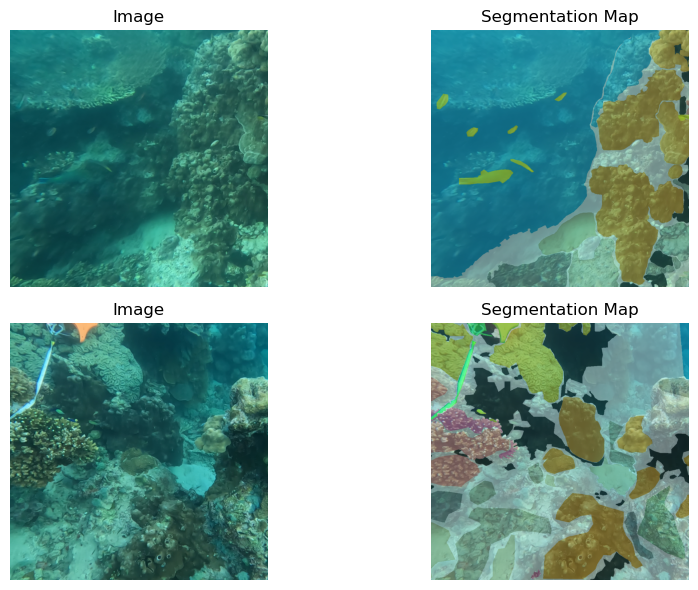

In [12]:
show_samples(train_dataset, n=2)

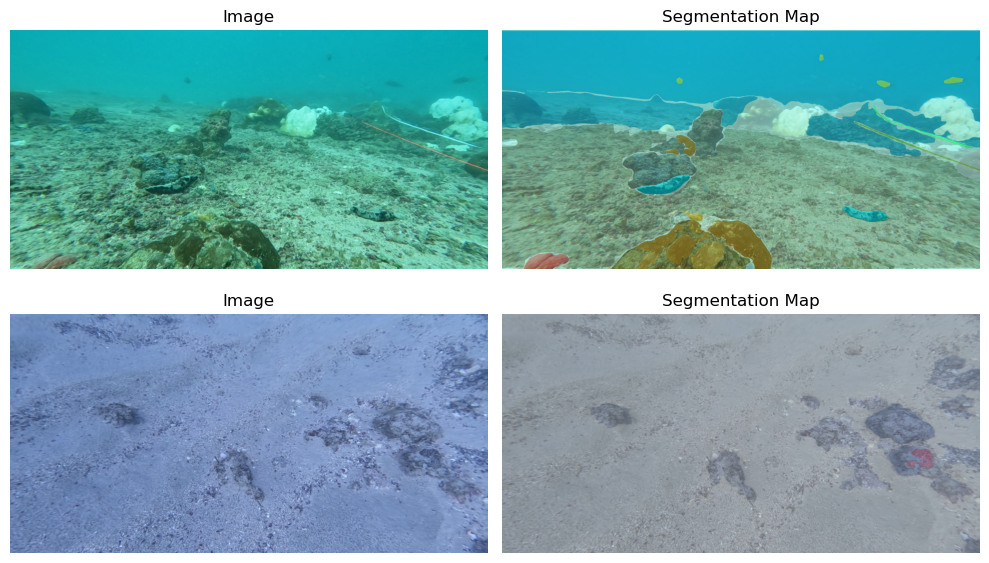

In [13]:
show_samples(val_dataset, n=2)

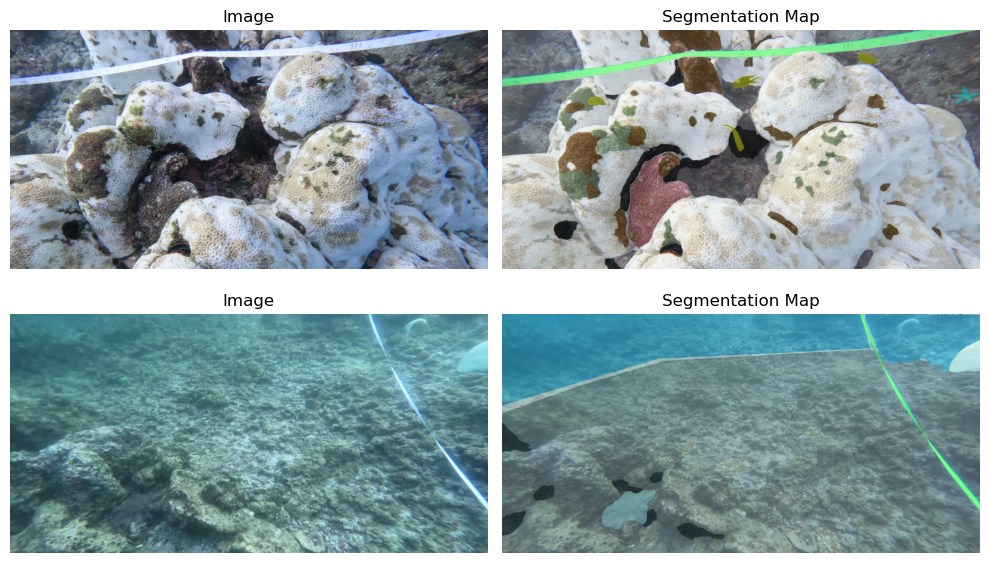

In [14]:
show_samples(test_dataset, n=2)

# Benchmarking

## Model

In [15]:
# cfg.model.checkpoint = "./model_checkpoints/deeplabv3plus_resnet50_kuma_run1/model_epoch950"
cfg.model.checkpoint = "./model_checkpoints/segformer_mit_b2_kuma_run1/model_epoch150"

In [16]:
benchmark_run = Benchmark_Run(run_name = cfg.run_name, model_name = cfg.model.name, 
                                    N_classes = train_dataset.N_classes, device= device, 
                                    model_kwargs = cfg.model.kwargs,
                                    model_checkpoint = cfg.model.checkpoint,
                                    lora_kwargs = cfg.lora,
                                    training_hyperparameters = cfg.training)

/home/viktor/micromamba/envs/coralscapes/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'ignore_index', 'num_labels'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weig

In [17]:
benchmark_run.print_trainable_parameters()

trainable params: 27377384 || all params: 27377384 || trainable%: 100.00


# Eval

## Base Metrics - Accuracy & mIoU

In [18]:
from coralscapesScripts.segmentation.eval import Evaluator 

if hasattr(benchmark_run, "preprocessor"):
    evaluator = Evaluator(N_classes = benchmark_run.N_classes, device = benchmark_run.device, preprocessor = benchmark_run.preprocessor, eval_params=benchmark_run.eval)  
else:
    evaluator = Evaluator(N_classes = benchmark_run.N_classes, device = benchmark_run.device, eval_params=benchmark_run.eval)  

In [19]:
train_metric_results = evaluator.evaluate_model(train_loader, benchmark_run.model, split = "train")
train_metric_results

{'accuracy': 0.9396631717681885, 'mean_iou': 0.8781961798667908}

In [20]:
val_metric_results = evaluator.evaluate_model(val_loader, benchmark_run.model, split = "val")
val_metric_results

{'accuracy': 0.7505295276641846, 'mean_iou': 0.4009273052215576}

In [21]:
test_metric_results = evaluator.evaluate_model(test_loader, benchmark_run.model, split = "test")
test_metric_results

{'accuracy': 0.8035838007926941, 'mean_iou': 0.5263180136680603}

## Other metrics - per class IoU
- https://lightning.ai/docs/torchmetrics/stable/

In [22]:
from torchmetrics.classification import JaccardIndex
import numpy as np 

metric_dict = {
            "iou": JaccardIndex(task="multiclass", num_classes=int(benchmark_run.N_classes), ignore_index = 0, average='none').to(device)
            }

if hasattr(benchmark_run, "preprocessor"):
    evaluator = Evaluator(metric_dict = metric_dict, N_classes = benchmark_run.N_classes, device = benchmark_run.device, preprocessor = benchmark_run.preprocessor, eval_params=benchmark_run.eval)  
else:
    evaluator = Evaluator(metric_dict = metric_dict, N_classes = benchmark_run.N_classes, device = benchmark_run.device, eval_params=benchmark_run.eval)  

In [23]:
test_metric_results = evaluator.evaluate_model(test_loader, benchmark_run.model, split = "test")
test_metric_results["iou"] = {train_dataset.id2label[class_id]:class_iou for class_id, class_iou in enumerate(test_metric_results["iou"])}
test_metric_results

{'iou': {'unlabeled': np.float32(0.0),
  'seagrass': np.float32(0.7343293),
  'trash': np.float32(0.0302096),
  'other coral dead': np.float32(0.057207324),
  'other coral bleached': np.float32(0.79089856),
  'sand': np.float32(0.8085976),
  'other coral alive': np.float32(0.49039024),
  'human': np.float32(0.7125389),
  'transect tools': np.float32(0.55671823),
  'fish': np.float32(0.57201314),
  'algae covered substrate': np.float32(0.63494366),
  'other animal': np.float32(0.33007637),
  'unknown hard substrate': np.float32(0.5699094),
  'background': np.float32(0.7995354),
  'dark': np.float32(0.6228531),
  'transect line': np.float32(0.7941962),
  'massive/meandering bleached': np.float32(0.61395234),
  'massive/meandering alive': np.float32(0.71916366),
  'rubble': np.float32(0.60935485),
  'branching bleached': np.float32(0.4624452),
  'branching dead': np.float32(0.4667823),
  'millepora': np.float32(0.7991103),
  'branching alive': np.float32(0.21982756),
  'massive/meandering

In [24]:
np.array(list(test_metric_results["iou"].values()))[1:].mean() #Ensure mean of the class IoUs matches the mIoU (excluding the unlabeled class)

np.float32(0.526318)

# Inference

In [25]:
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt 
from coralscapesScripts.visualization import color_label, color_correctness

from coralscapesScripts.datasets.preprocess import preprocess_inference
from coralscapesScripts.segmentation.model import predict

In [26]:
inference_image_file_path = test_dataset.images[42]
inference_image = np.array(Image.open(inference_image_file_path).convert('RGB'))

inference_image_target = test_dataset.targets[42]
inference_target = np.array(Image.open(inference_image_target))
inference_target_colors = color_label(inference_target)

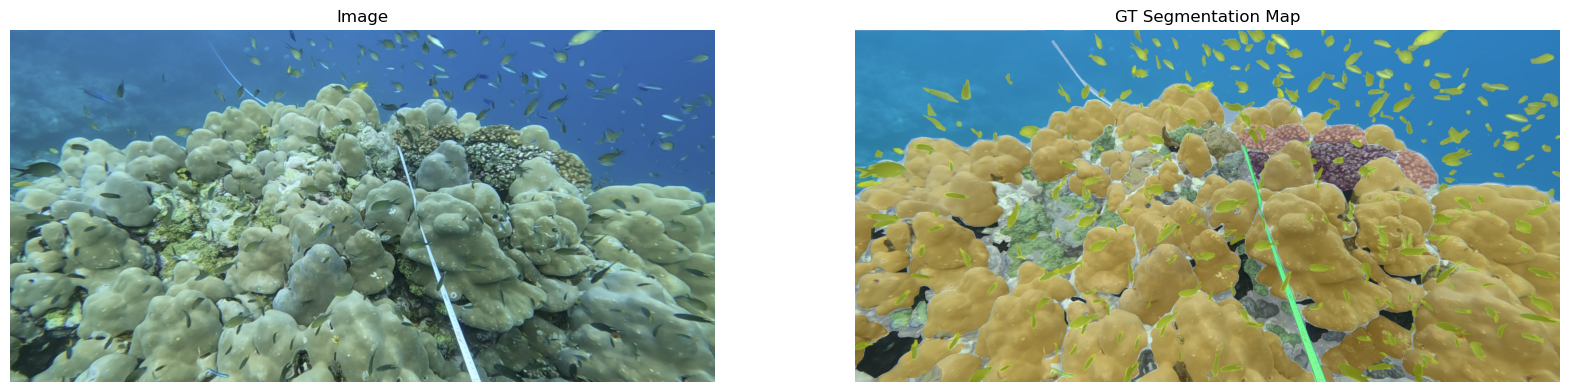

In [27]:
fig, ax = plt.subplots(figsize=(20,5), ncols = 2)
ax[0].imshow(inference_image)
ax[0].set_title("Image")
ax[0].axis("off")
ax[1].imshow(inference_image)
ax[1].imshow(inference_target_colors, alpha = 0.4)
ax[1].set_title("GT Segmentation Map")
ax[1].axis("off")
plt.show()

In [28]:
preprocessed_batch, window_dims = preprocess_inference(inference_image, transforms["test"], benchmark_run)

In [29]:
benchmark_run.model.eval()
with torch.no_grad():
    inference_prediction = predict(preprocessed_batch, 
                                    benchmark_run,
                                    window_dims = window_dims)

In [30]:
inference_prediction_colors = color_label(inference_prediction)
inference_correctness = color_correctness(inference_target, inference_prediction)

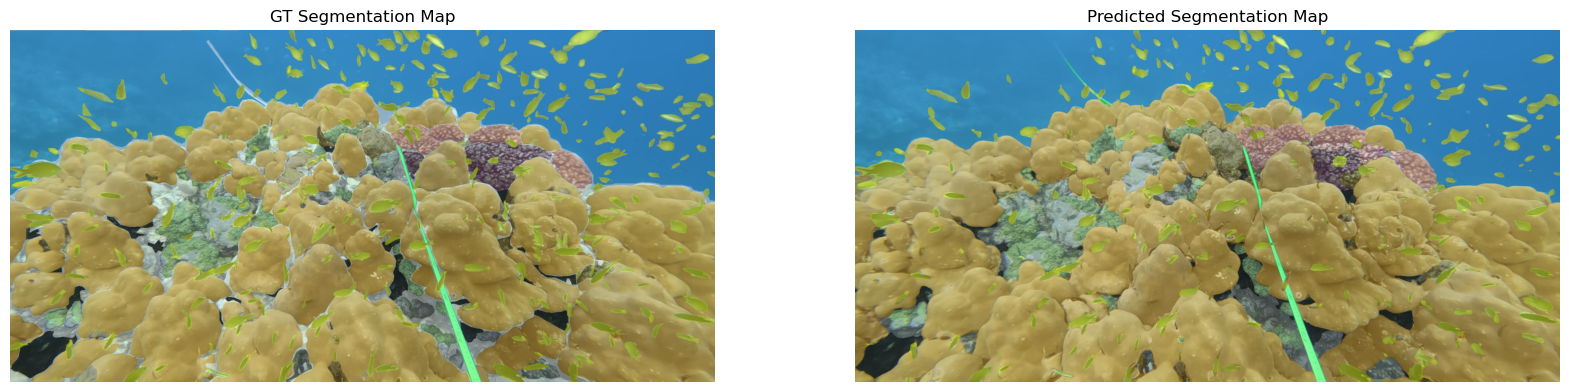

In [31]:
fig, ax = plt.subplots(figsize=(20,5), ncols = 2)
ax[0].imshow(inference_image)
ax[0].imshow(inference_target_colors, alpha = 0.4)
ax[0].set_title("GT Segmentation Map")
ax[0].axis("off")
ax[1].imshow(inference_image)
ax[1].imshow(inference_prediction_colors, alpha = 0.4)
ax[1].set_title("Predicted Segmentation Map")
ax[1].axis("off")
plt.show()

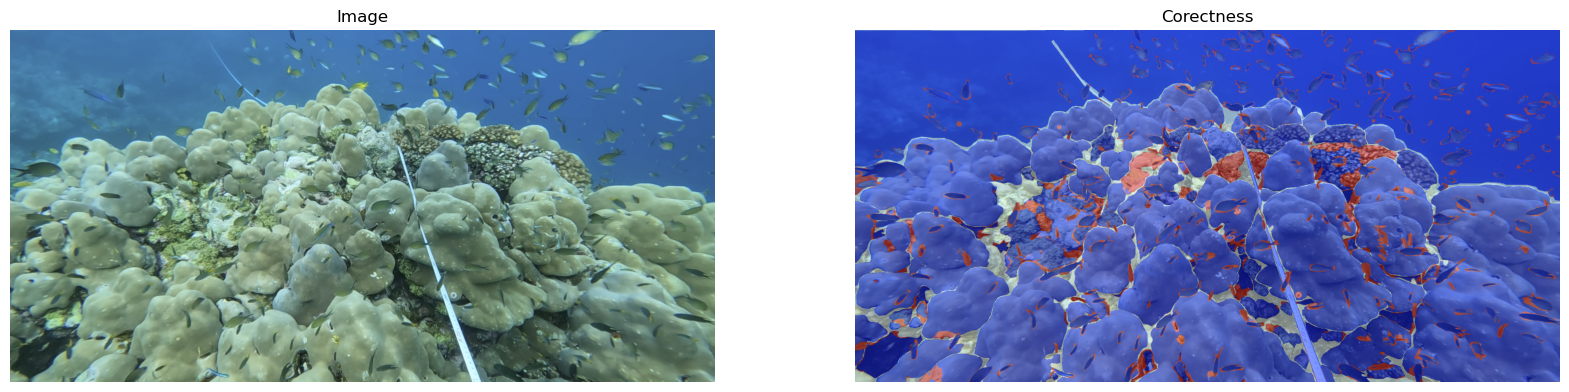

In [32]:
fig, ax = plt.subplots(figsize=(20,5), ncols = 2)
ax[0].imshow(inference_image)
ax[0].set_title("Image")
ax[0].axis("off")
ax[1].imshow(inference_image)
ax[1].imshow(inference_correctness, alpha = 0.4)
ax[1].set_title("Corectness")
ax[1].axis("off")
plt.show()